In [2]:
import itertools
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf

import torch
from tqdm.auto import tqdm

import body_models
from datamodules import MoCapDataModule
from train import LitVAE

In [3]:
OmegaConf.register_new_resolver("hydra", lambda x: '.')

In [4]:
def get_data_and_recon(run_dir, n_samples=None):
    cfg = run_dir / '.hydra' / 'config.yaml'
    cfg = OmegaConf.load(cfg)
    cfg.data_path = cfg.data_path.replace('${hydra:runtime.cwd}', '.')
    
    ckpt = (run_dir / 'lightning_logs' / 'version_0' / 'checkpoints').glob('epoch*.ckpt')
    ckpt = next(iter(ckpt))

    model = LitVAE.load_from_checkpoint(ckpt).cuda()
    
    dm = MoCapDataModule(
        cfg.data_path,
        train=cfg.train_split,
        valid=cfg.valid_split,
        test=cfg.test_split,
        batch_size=512
    )

    dm.setup()
    dm.prepare_data()

    # minX, minY, minZ = dm.predict_dataset.tensors[0].numpy().min(axis=(0, 1, 2))
    # maxX, maxY, maxZ = dm.predict_dataset.tensors[0].numpy().max(axis=(0, 1, 2))
    
    # ids_and_samples = zip(dm.test_ids, dm.test_dataloader())
    # ids_and_samples = itertools.islice(ids_and_samples, 0, None, cfg.every_n)
    # ids_and_samples = itertools.islice(ids_and_samples, 0, cfg.limit)

    xs, xs_hat = [], []
    with torch.no_grad():
        for (x,) in tqdm(dm.test_dataloader()):
            mu, _ = model.encode(x.cuda())
            x_mu, _ = model.decode(mu)
            xs.append(x.cpu().numpy())
            xs_hat.append(x_mu.cpu().numpy())

    xs = np.concatenate(xs)
    xs_hat = np.concatenate(xs_hat)

    if n_samples:
        sample = np.random.default_rng(7).choice(len(xs), n_samples)
        xs = xs[sample]
        xs_hat = xs_hat[sample]
    
    return xs, xs_hat, cfg

In [5]:
def pick_best_worst(xs, xs_hat, n_best=1, n_worst=1, buffer=20):
    n, d, j, c = xs.shape
    
    l2 = np.sum((xs - xs_hat)**2, axis=(1,2,3))
    
    motion_factor = np.sum(np.diff(xs.reshape(n, d, j*c), axis=1) ** 2, axis=(1,2))
    idx = motion_factor.argsort()[::-1][:100]
    
    sortedl2 = l2[idx].argsort()
    best = idx[sortedl2[:buffer]]
    worst = idx[sortedl2[-buffer:]]

    rb = np.random.default_rng(7).choice(buffer, n_best)
    rw = np.random.default_rng(7).choice(buffer, n_worst)
    
    idx = np.concatenate((best[rb], worst[rw]))
    
    return xs[idx], xs_hat[idx]

In [6]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_pose(ax, pose, color, edges, label=None):
    artists = []
    for i, (start, end) in enumerate(edges):
        _label = label if i == 0 else None
        x0, y0, z0 = pose[start]
        x1, y1, z1 = pose[end]
        artist = ax.plot([x0, x1], [y0, y1], [z0, z1], c=color, zdir='x', label=_label)
        artists.extend(artist)
    
    return artists


def draw_strip(xs, xs_hat, body_model, s=2):
    body_model = body_models.get_by_name(body_model)
    edges = body_model.edges
    xlim = body_model.xlim
    ylim = body_model.ylim
    zlim = body_model.zlim
    n, d, j, c = xs.shape
    
    fig, axes = plt.subplots(n, d, figsize=(n*8, d*0.5), subplot_kw=dict(projection='3d'))
    for i in range(n):
        for j in range(d):
            ax = axes[i,j]
            ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([s, s, s, 1]))
            ax.set(xlim=xlim, xticks=[],
                   ylim=ylim, yticks=[],
                   zlim=zlim, zticks=[])
            #ax.grid(False)
            ax.set_axis_off()
            # ax.set_box_aspect(aspect = (5,5,5))
            ax.get_proj()
            
            visualize_pose(ax, xs    [i,j], 'b', edges, label='Orig')
            visualize_pose(ax, xs_hat[i,j], 'r', edges, label='Recon')
    
    for j in range(d):
        axes[0,j].set_title(fr'$P_{{{j+1}}}$', fontdict=dict(fontsize=16))
    
    # axes[0,3].legend(loc='lower right')
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig

train_dataset len: 19671
valid_dataset len: 4297
test_dataset len: 4136
predict_dataset len: 28104


  0%|          | 0/9 [00:00<?, ?it/s]

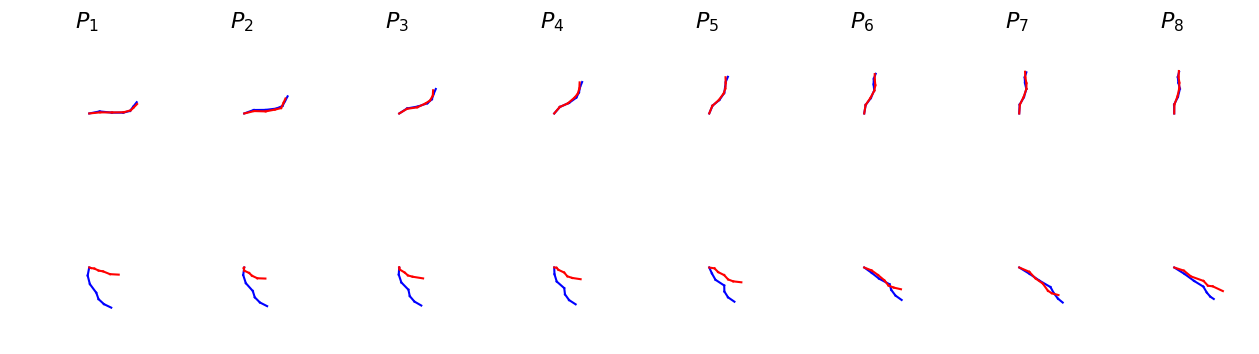

In [7]:
run_dir = Path('runs/hdm05/all/beta=1,body_model=hdm05-torso,latent_dim=64')
xs, xs_hat, cfg = get_data_and_recon(run_dir, n_samples=1000)
x, x_hat = pick_best_worst(xs, xs_hat, n_best=1, n_worst=1)
draw_strip(x, x_hat, cfg.body_model)
DIR_NAME='runs/hdm05/all/beta=1,body_model=hdm05-torso,latent_dim=64/figures/recon-hdm05.pdf'
os.makedirs(os.path.dirname(DIR_NAME), exist_ok=True)
plt.savefig(DIR_NAME, bbox_inches='tight')

In [ ]:
run_dir = Path('runs/pku-mmd/cv/beta=1,latent_dim=32')
xs, xs_hat, cfg = get_data_and_recon(run_dir, n_samples=1000)
x, x_hat = pick_best_worst(xs, xs_hat, n_best=1, n_worst=1)
draw_strip(x, x_hat, cfg.body_model)
plt.savefig('figures/recon-pku-cv.pdf', bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '/home/drking/Documents/bakalarka/mocap-vae-features/runs/pku-mmd/cv/beta=1,latent_dim=256/.hydra/config.yaml'

train_dataset len: 1076378
valid_dataset len: 147780
test_dataset len: 147780
predict_dataset len: 1224158


  0%|          | 0/289 [00:00<?, ?it/s]

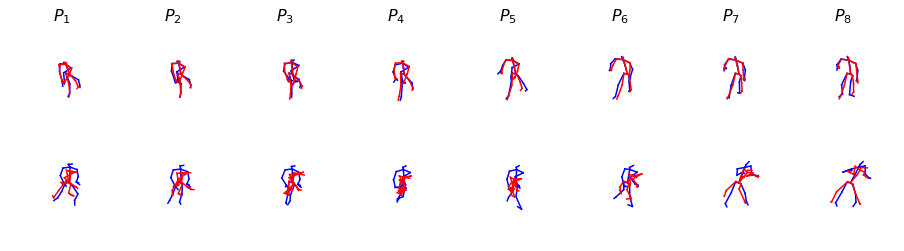

In [ ]:
run_dir = Path('runs/pku-mmd/cs/beta=1,latent_dim=256')
xs, xs_hat, cfg = get_data_and_recon(run_dir, n_samples=1000)
x, x_hat = pick_best_worst(xs, xs_hat, n_best=1, n_worst=1)
draw_strip(x, x_hat, cfg.body_model)
plt.savefig('figures/recon-pku-cs.pdf', bbox_inches='tight')